# World Data League 2021
## **Predicting the demand for shared bicycles**

## Context

The Metropolitan Area of the Aburrá Valley acts as a metropolitan public transport authority and urban environmental authority. Hence, almost ten years ago, it implemented the Public Bicycle System of the Aburrá Valley – EnCicla to offer a free alternative of sustainable mobility through the loan of bicycles for up to an hour to users registered in the system.

It currently has more than 1,600 bicycles in 101 stations, from which an average daily of 7,600 loans are made during the pandemic.

The goal is to create a model that allows us to make system load balancing decisions based on demand forecasting based on historical data. Load balancing means the planning of transporting bicycles from one station to another.

## Goals

Have a model that helps planning the transportation of bicycles from one station to another.

## Outcome

 - An analysis on stations to understand if there are variables that make any impact on bike rental, making them deserve more attention.
 - A model that helps in making predictions for bike rentals and therefore help forecast when it is needed to send for transportation from one station to another.
 
## **1. Introduction**

Our objective was first to understand the context of each station and see if there is any correlation between its features and its number of bike rentals, for that we made a general literature review to understand motivation behind use of bicycles. There was also another review for knowing what had been already done for bicycle load load balancing.

## General Literature Review

1. In Poland, there were 4 types of ciclists: conscious, forced, pro-health, lifestyle cyclists[1];
2. The same paper identifies the requirement for basic facilities as a motivator (parking place, cloakrooms, showers)[1];
3. Lack of a car enforces cycling[1];
4. Inhabitants of rural areas and towns perform it more often than city dwellers, except for the 5 lasgerst Polish cities in Poland. We can imagine a 2nd order polynomial function for bike use vs population[1];
5. Davis (U.S) and Delft (Netherlands) give a lot of importance to health for commuting by bicycle. Safety is more of an issue for  Davis respondents[2];
6. Bicycle infrastructure plays a role in the consideration of whether or not to cycle to work [2];
7. Beijing had several detractors for the failure of the first generation of the first generation of public bicycle system: Lack of safety on cyclist, Deteriorated conditions of public bicycle equipments, Unattractive fare and Inexplicit policy orientation[3];

The previous literature used the general information to understand the users of bicycles.  Two papers informs us of a similar attempt to predict user demand for each station:

1. LSTM model used to make demand prediction using drop-off demand and pick-up demand for each station as well as weather data [4].
2. Multiple models were used to make pick-up and drop-off forecasting. Clustering algorithms were also used to identify important stations to target for rebanlancing and leave out outliers. This used loan data and weather data alike[5].

---
[1] Biernat E., Buchholtz S., Bartkiewicz P., "Motivations and barriers to bicycle commuting: Lessons from Poland", Transportation Research Part F: Traffic Psychology and Behaviour
Volume 55, May 2018, Pages 492-502, https://doi.org/10.1016/j.trf.2018.03.024  
[2] Eva Heinen & Susan Handy (2012) Similarities in Attitudes and Norms and the Effect on Bicycle Commuting: Evidence from the Bicycle Cities Davis and Delft, International Journal of Sustainable Transportation, 6:5, 257-281, DOI: 10.1080/15568318.2011.593695  
[3] Zhili Liu, Xudong Jia, Wen Cheng, "Solving the Last Mile Problem: Ensure the Success of Public Bicycle System in Beijing", Procedia - Social and Behavioral Sciences
Volume 43, 2012, Pages 73-78, https://doi.org/10.1016/j.sbspro.2012.04.079  
[4] P. Mrazovic, J. L. Larriba-Pey and M. Matskin, "A Deep Learning Approach for Estimating Inventory Rebalancing Demand in Bicycle Sharing Systems," 2018 IEEE 42nd Annual Computer Software and Applications Conference (COMPSAC), 2018, pp. 110-115, doi: 10.1109/COMPSAC.2018.10213.  
[5] J. Liu, L. Sun et al., "Rebalancing bike sharing systems: A multi-source data smart optimization", Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 1005-1014, 2016.


## Metrics to obtain

In this work we will:
* Visualize the **elevation** of a station with the **number of bicycle rentals**.
* See if an LSTM can make any kind of prediction with the daily bicycle rentals for one station.

## Data

All the data used is provided by the organizers of the competiton

## **2. Development**

## Elevation Vs. Bicycle Rentals

We will first get the station information, and that includes getting their geolocation.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
import rasterio
import contextily as ctx
import numpy as np
import pmdarima as pm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import plotly
import plotly.graph_objects as go

%matplotlib inline

In [2]:
# Load stations information
stations = pd.read_csv('data/station_location_with_id.csv', sep=';')
stations.head()

,ID,Description,numSlots,shortName,Lat,Lon,isManual,webDescription,photo
0,1,Moravia,15,MRV,"6,276585","-75,564804",1,Frente a la entrada principal del Centro de De...,https://encicla.metropol.gov.co/imgstations/mo...
1,2,Universidad,33,UNI,"6,269267","-75,5653",1,Bajo el viaducto de la estación Universidad de...,https://encicla.metropol.gov.co/imgstations/un...
2,3,Ruta N,40,RTN,"6,265182","-75,566348",0,Frente a la fachada principal de Ruta N sobre ...,https://encicla.metropol.gov.co/imgstations/ru...
3,4,Punto Cero,10,PT0,"6,265161","-75,575066",1,Intercambio vial de Punto Cero al lado de la e...,https://encicla.metropol.gov.co/imgstations/pu...
4,5,Universidad Nacional,33,NaN,"6,259663","-75,578812",1,Portería de la Iguaná con Carrera 65 de la Uni...,https://encicla.metropol.gov.co/imgstations/un...


In [3]:
# Convert Lat and Lon to floats to use as coordinates
for col in ['Lat', 'Lon']:
    stations[col] = stations[col].str.replace(',', '.')
    stations[col] = stations[col].astype(float)

In [4]:
# Create GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.Lon, stations.Lat), crs=4326)

In [5]:
# Get elevation data
elevations = []
for index, row in stations_gdf.iterrows():
    # Extract atributes from the stations df
    latitude = row['geometry'].y
    longitude = row['geometry'].x
    
    # Reading the DEM using rasterio (it has Projetion System EPSG:4326)
    dem = rasterio.open('data/med_elevation_30m_srtm.tif')
    row, col = dem.index(longitude, latitude)
    dem_data = dem.read(1)
    
    elevations.append(dem_data[row, col]) 
    
stations_gdf['elevation'] = elevations
stations_gdf.head()

,ID,Description,numSlots,shortName,Lat,Lon,isManual,webDescription,photo,geometry,elevation
0,1,Moravia,15,MRV,6.276585,-75.564804,1,Frente a la entrada principal del Centro de De...,https://encicla.metropol.gov.co/imgstations/mo...,POINT (-75.56480 6.27658),1458
1,2,Universidad,33,UNI,6.269267,-75.565300,1,Bajo el viaducto de la estación Universidad de...,https://encicla.metropol.gov.co/imgstations/un...,POINT (-75.56530 6.26927),1468
2,3,Ruta N,40,RTN,6.265182,-75.566348,0,Frente a la fachada principal de Ruta N sobre ...,https://encicla.metropol.gov.co/imgstations/ru...,POINT (-75.56635 6.26518),1467
3,4,Punto Cero,10,PT0,6.265161,-75.575066,1,Intercambio vial de Punto Cero al lado de la e...,https://encicla.metropol.gov.co/imgstations/pu...,POINT (-75.57507 6.26516),1460
4,5,Universidad Nacional,33,NaN,6.259663,-75.578812,1,Portería de la Iguaná con Carrera 65 de la Uni...,https://encicla.metropol.gov.co/imgstations/un...,POINT (-75.57881 6.25966),1468


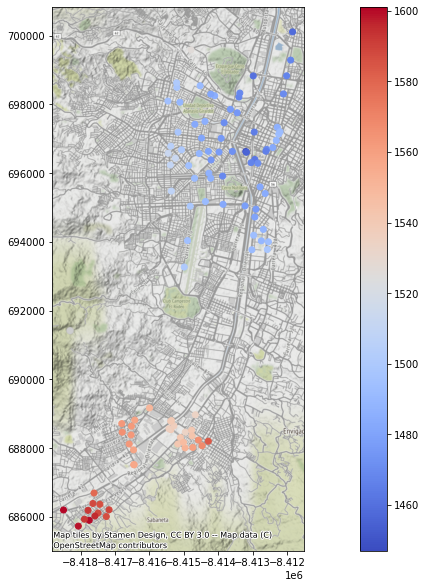

In [6]:
stations_gdf = stations_gdf.to_crs(epsg=3857)
ax = stations_gdf.plot(figsize=(20,10), column='elevation', legend=True, cmap='coolwarm')
ctx.add_basemap(ax)

First analyses shows us that southern stations are all in a higher elevation that the ones in the north. We will now compare with the daily averages for bike rentals in 2020.

In [7]:
# Lets check which station IDs do we have
stationIDs = stations.ID.unique()
print(stationIDs)

# We will only use these stations

[  1   2   3   4   5   6   7   8   9  10  11  12  13  19  20  21  22  23
  24  27  28  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  51  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  70  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 118 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142]


In [37]:
# This cell gets the pick-ups and drop-offs for each day for each station. This will also be used for making predictions in demand
%%time
run=False

if run:
    for i in stationIDs:

        main_data = pd.read_csv('data/bike_loans.csv', 
                            sep=';', 
                            chunksize=1000000, 
                            usecols=[3,4,5,7], 
                            header=0, 
                           )
        dfi = pd.DataFrame()

        for data in main_data:
            pickups = pd.to_datetime(data[data.Id_Aparcamiento_Origen==i]['Fecha_Prestamo'])
            pickups = pickups.groupby(pickups.dt.floor('d')).size().reset_index(name='Pick-Ups')
            dropoffs = pd.to_datetime(data[data.Id_Aparcamiento_Destino==i]['Fecha_Devolucion'])
            dropoffs = dropoffs.groupby(dropoffs.dt.floor('d')).size().reset_index(name='Drop-Offs')
            join_data = pickups.merge(dropoffs, how='outer', left_on='Fecha_Prestamo', right_on='Fecha_Devolucion')
            join_data.loc[join_data.Fecha_Prestamo.isna(), 'Fecha_Prestamo'] = join_data.loc[join_data.Fecha_Prestamo.isna(), 'Fecha_Devolucion']
            join_data = join_data.drop(columns=['Fecha_Devolucion'])
            join_data = join_data.rename(columns={'Fecha_Prestamo': 'Day'})
            dfi = pd.concat([dfi, join_data])
        dfi = dfi.groupby(by=['Day']).sum().reset_index()
        dfi.to_csv(f'data/station_data/{i}_ins_outs.csv', index=False)

CPU times: user 30min 12s, sys: 54.6 s, total: 31min 6s
Wall time: 31min 7s


In [8]:
# After we obtain CSVs for all of the stations, we can now calculate the daily averages for 2020
daily_averages = []
days = []
for i in stationIDs:
    dfi = pd.read_csv(f'data/station_data/{i}_ins_outs.csv')
    avg = dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['Pick-Ups'].mean()
    count = dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['Pick-Ups'].count()
    daily_averages.append(avg)
    days.append(count)
    
station_daily_averages = pd.DataFrame({'station': stationIDs, 'daily_avgs_2020': daily_averages, 'days_of_use': days})

In [9]:
station_daily_averages.head()

,station,daily_avgs_2020,days_of_use
0,1,250.582090,268
1,2,243.438662,269
2,3,175.128676,272
3,4,155.492754,69
4,5,152.724638,69


Before we proceed lets give a look to the daily averages to understand if we can use them all. To investigate this we are going to check the number of days that the stations were operational

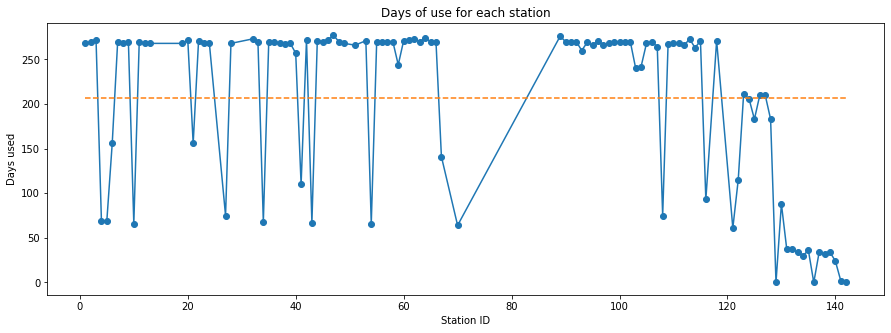

In [10]:
fig,ax = plt.subplots(figsize=(15,5))

x = station_daily_averages['station']
y = station_daily_averages['days_of_use']

y_mean = [np.mean(y)]*len(x)

data_line = ax.plot(x, y, label='Days used', marker='o')
mean_line = ax.plot(x, y_mean, label='Mean', linestyle='--')
                    
plt.title('Days of use for each station');
plt.xlabel('Station ID')
plt.ylabel('Days used');

In [11]:
# Here is a sample of the stations that are below average in days of use
to_analyse_stations = station_daily_averages[station_daily_averages.days_of_use < y_mean]
to_analyse_stations.head()

,station,daily_avgs_2020,days_of_use
3,4,155.492754,69
4,5,152.724638,69
5,6,167.185897,156
9,10,302.878788,66
15,21,154.692308,156


We are going to iterate through these stations and understand for analyse for each of them if any of the follow scenarios happened in 2020:
* They only initiated their work later in the year;
* They stopped working sometime during the year;
* If they work work only with some periodicity.

In [12]:
periodicity = []
first_date = []
last_date = []
for i in to_analyse_stations['station']:
    dfi = pd.read_csv(f'data/station_data/{i}_ins_outs.csv')
    first = dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['Day'].min()
    last = dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['Day'].max()
    # Get the day in the year
    dfi['Day'] = pd.to_datetime(dfi.Day)
    dfi['day_of_year'] = dfi.Day.apply(lambda x: x.timetuple().tm_yday)
    dfi['days_since_last_use'] = dfi['day_of_year'].sub(dfi['day_of_year'].shift())
    average_days_periodicity = np.mean(dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['day_of_year'].sub(dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['day_of_year'].shift()))
    periodicity.append(average_days_periodicity)
    first_date.append(first)
    last_date.append(last)
    
analyse_stations = pd.DataFrame({'station': to_analyse_stations['station'], 'first_date_of_use': first_date, 'last_date_of_use': last_date, 'periodicity': periodicity, 'Days_of_use': to_analyse_stations['days_of_use']})
analyse_stations.head(50)

,station,first_date_of_use,last_date_of_use,periodicity,Days_of_use
3,4,2020-01-02,2020-07-02,2.676471,69
4,5,2020-01-02,2020-12-02,4.926471,69
5,6,2020-01-02,2020-12-31,2.348387,156
9,10,2020-01-02,2020-03-19,1.184615,66
15,21,2020-01-02,2020-12-31,2.348387,156
19,27,2020-01-02,2020-12-19,4.756757,75
23,34,2020-01-02,2020-07-22,3.014925,68
30,41,2020-01-02,2020-12-23,3.266055,110
32,43,2020-01-02,2020-03-20,1.181818,67
41,54,2020-01-02,2020-03-19,1.184615,66


From this table there are a lot of conclusions we can take from it:
* Some stations are not used: 129, 136, 141 and 142;
* Some stations started to be used in 2020, they started after a certain date and have a periodicity of use of close to 1 day (e.g 88, 137, 138)
* Some stations seem to have been discontinued, could be due to low use (e.g. 4, 34) or just by choice (e.g. 10, 70)

To avoid randomization errors we will use an n > 100 days of use to visualize the stations use in a year.

In [13]:
station_daily_averages = station_daily_averages[station_daily_averages.days_of_use > 100]

In [14]:
stations_gdf_pickups = stations_gdf.merge(station_daily_averages, how='inner', left_on='ID', right_on='station').drop(columns=['station']).copy()

In [15]:
stations_gdf_pickups.head()

,ID,Description,numSlots,shortName,Lat,Lon,isManual,webDescription,photo,geometry,elevation,daily_avgs_2020,days_of_use
0,1,Moravia,15,MRV,6.276585,-75.564804,1,Frente a la entrada principal del Centro de De...,https://encicla.metropol.gov.co/imgstations/mo...,POINT (-8411835.503 700107.931),1458,250.582090,268
1,2,Universidad,33,UNI,6.269267,-75.565300,1,Bajo el viaducto de la estación Universidad de...,https://encicla.metropol.gov.co/imgstations/un...,POINT (-8411890.718 699288.388),1468,243.438662,269
2,3,Ruta N,40,RTN,6.265182,-75.566348,0,Frente a la fachada principal de Ruta N sobre ...,https://encicla.metropol.gov.co/imgstations/ru...,POINT (-8412007.380 698830.914),1467,175.128676,272
3,6,Colombia,12,COL,6.256490,-75.581024,1,Esquina occidental de la Carrera 65 con Calle 51,https://encicla.metropol.gov.co/imgstations/co...,POINT (-8413641.105 697857.520),1477,167.185897,156
4,7,Suramericana,20,SUR,6.253003,-75.582687,1,Bajo el viaducto de la estación Suramericana d...,https://encicla.metropol.gov.co/imgstations/su...,POINT (-8413826.230 697467.024),1471,315.929368,269


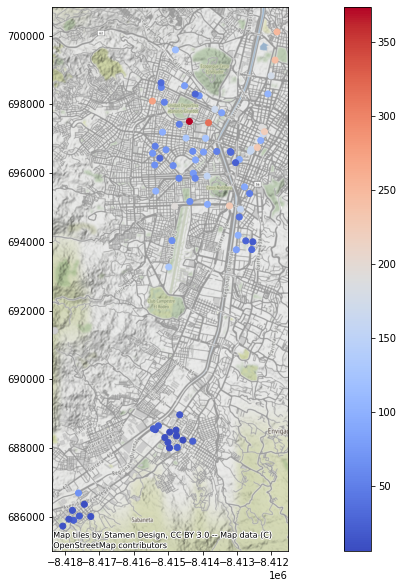

In [16]:
ax = stations_gdf_pickups.plot(figsize=(20,10), column='daily_avgs_2020', legend=True, cmap='coolwarm')
ctx.add_basemap(ax)

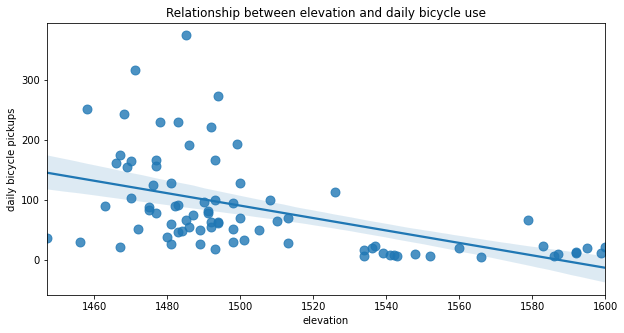

In [17]:
plt.figure(figsize=(10,5))
sns.regplot(data = stations_gdf_pickups, x='elevation', y='daily_avgs_2020', order=1, scatter_kws={"s": 80})
plt.xlabel('elevation')
plt.ylabel('daily bicycle pickups')
plt.title('Relationship between elevation and daily bicycle use');

Through both plots we can clearly see a correlation between the elevation with the daily bicycle use. In this case it is a negative correlation: the higher the elevation, the less the bicycle use. 

### Drop Off Data

We will now see if the same happens with the drop-offs.

In [18]:
# After we obtain CSVs for all of the stations, we can now calculate the daily averages for 2020
daily_averages = []
days = []
for i in stationIDs:
    dfi = pd.read_csv(f'data/station_data/{i}_ins_outs.csv')
    avg = dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['Drop-Offs'].mean()
    count = dfi[(dfi.Day > '2020-01-01') & (dfi.Day < '2021-01-01' )]['Drop-Offs'].count()
    daily_averages.append(avg)
    days.append(count)
    
station_daily_averages = pd.DataFrame({'station': stationIDs, 'daily_avgs_2020': daily_averages, 'days_of_use': days})

In [19]:
station_daily_averages = station_daily_averages[station_daily_averages.days_of_use > 100]

In [20]:
stations_gdf_dropoffs= stations_gdf.merge(station_daily_averages, how='inner', left_on='ID', right_on='station').drop(columns=['station']).copy()

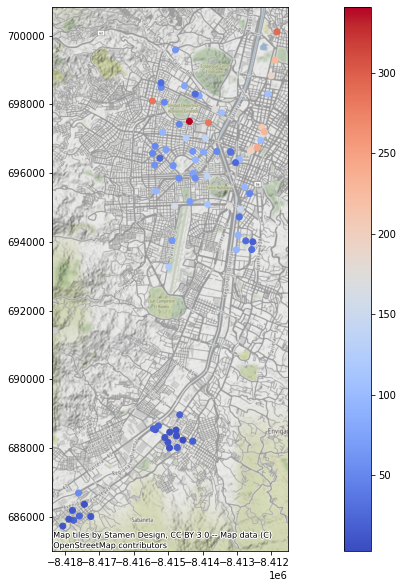

In [21]:
ax = stations_gdf_dropoffs.plot(figsize=(20,10), column='daily_avgs_2020', legend=True, cmap='coolwarm')
ctx.add_basemap(ax)

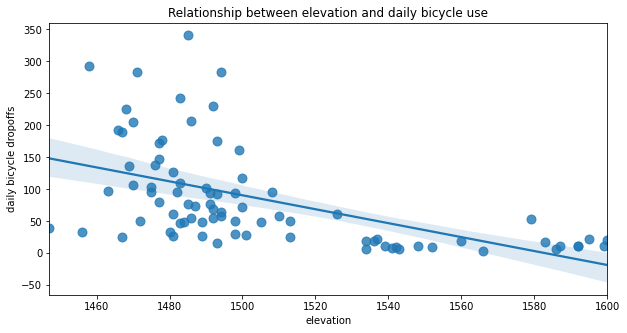

In [22]:
plt.figure(figsize=(10,5))
sns.regplot(data = stations_gdf_dropoffs, x='elevation', y='daily_avgs_2020', order=1, scatter_kws={"s": 80})
plt.xlabel('elevation')
plt.ylabel('daily bicycle dropoffs')
plt.title('Relationship between elevation and daily bicycle use');

Again the relationship with drop-off data is very similar, but this happens because the number of pickups is very similar to the number of dropoffs for each day. This can happen because maintenance workers are balancing the bicycle use, or it might happen because people who normaly use the bike in one direction in the morning, use it in the opposite direction to come back.

## Forecasting bike demand

To make an attempt at forecasting we will use the hourly data from station 1.

In [24]:
run = False
if run:
    main_data = pd.read_csv('data/bike_loans.csv', 
                        sep=';', 
                        chunksize=1000000, 
                        usecols=[3,4,5,7], 
                        header=0, 
                       )
    dfi = pd.DataFrame()

    for data in main_data:
        pickups = pd.to_datetime(data[data.Id_Aparcamiento_Origen==1]['Fecha_Prestamo'])
        pickups = pickups.groupby(pickups.dt.floor('H')).size().reset_index(name='Pick-Ups')
        dropoffs = pd.to_datetime(data[data.Id_Aparcamiento_Destino==1]['Fecha_Devolucion'])
        dropoffs = dropoffs.groupby(dropoffs.dt.floor('H')).size().reset_index(name='Drop-Offs')
        join_data = pickups.merge(dropoffs, how='outer', left_on='Fecha_Prestamo', right_on='Fecha_Devolucion')
        join_data.loc[join_data.Fecha_Prestamo.isna(), 'Fecha_Prestamo'] = join_data.loc[join_data.Fecha_Prestamo.isna(), 'Fecha_Devolucion']
        join_data = join_data.drop(columns=['Fecha_Devolucion'])
        join_data = join_data.rename(columns={'Fecha_Prestamo': 'day_hour'})
        dfi = pd.concat([dfi, join_data])
    dfi = dfi.groupby(by=['day_hour']).sum().reset_index()
    dfi.to_csv('data/station_data/1_hourly_demand.csv', index=False)
else:
    dfi = pd.read_csv('data/station_data/1_hourly_demand.csv')

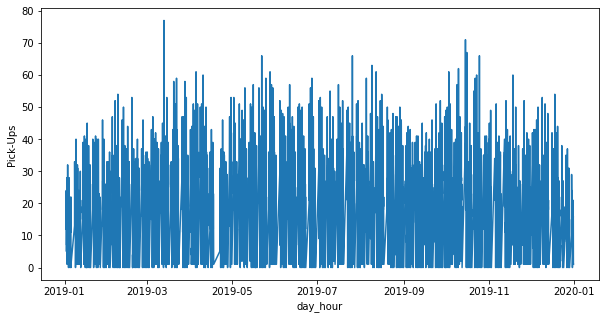

In [31]:
# Let's visualize the data for 2019
dfi['day_hour'] = pd.to_datetime(dfi['day_hour'])
df_2019 = dfi[(dfi.day_hour > '2019/01/01') & (dfi.day_hour < '2020/01/01')].copy()
plt.figure(figsize=(10,5))
sns.lineplot(data=df_2019 , x='day_hour', y='Pick-Ups');

There seems to exist some periodicity in this year.
To verify this, we will check the mean values for each hour in 2019.

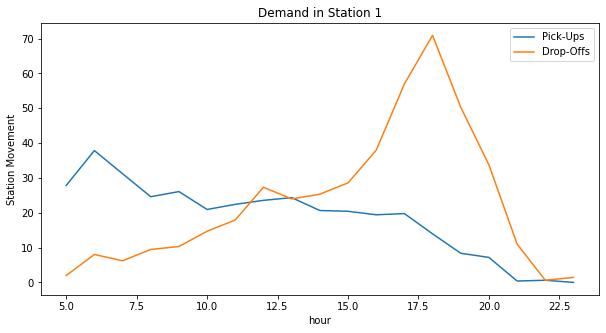

In [32]:
df_2019['hour'] = df_2019.day_hour.apply(lambda x: x.hour)
df_2019_hour = df_2019.groupby(by='hour').mean().reset_index()
df_2019_hour['hour'] = df_2019_hour['hour'].astype(int)
fig, axes = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_2019_hour , x='hour', y='Pick-Ups', label='Pick-Ups')
sns.lineplot(data=df_2019_hour , x='hour', y='Drop-Offs', label='Drop-Offs')
plt.title('Demand in Station 1')
plt.ylabel('Station Movement');

In this case, this station has more pick-ups during the morning and more drop-offs in the afternoon. This should be a case where the station is located near a residential area and people pick up bicycles to go to work or university and then come back to after work hours.

Now let's see if there is any change by days of the week

In [33]:
df_2019_day = pd.read_csv('data/station_data/1_ins_outs.csv')
df_2019_day.head()

,Day,Pick-Ups,Drop-Offs
0,2014-05-30,4.0,3.0
1,2014-06-01,1.0,2.0
2,2014-06-02,1.0,1.0
3,2014-06-03,29.0,15.0
4,2014-06-04,39.0,32.0


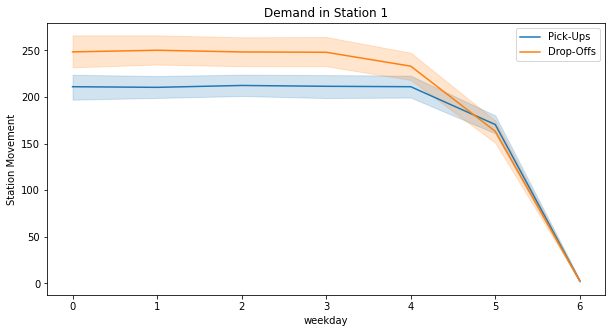

In [34]:
df_2019_day['weekday'] = pd.to_datetime(df_2019_day.Day).dt.dayofweek
df_2019_day['weekday'] = df_2019_day['weekday'].astype(int)
fig, axes = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_2019_day , x='weekday', y='Pick-Ups', label='Pick-Ups')
sns.lineplot(data=df_2019_day , x='weekday', y='Drop-Offs', label='Drop-Offs')
plt.title('Demand in Station 1')
plt.ylabel('Station Movement');

Again, what happens here is that demand is pratically the same for week days, is smaller for saturdays and 0 for sundays which probably happens because the service is closed during those days.

### Making the actual predictions

### SARIMA

In [35]:
series = pd.read_csv('data/station_data/1_hourly_demand.csv')
series['day_hour'] = pd.to_datetime(series['day_hour'])
series = series[(series.day_hour > '2019/01/01') & (series.day_hour < '2020/01/01')]
series=series[len(series)-1000:]
series.head()

,day_hour,Pick-Ups,Drop-Offs
21911,2019-10-17 13:00:00,23.0,27.0
21912,2019-10-17 14:00:00,27.0,32.0
21913,2019-10-17 15:00:00,22.0,33.0
21914,2019-10-17 16:00:00,16.0,59.0
21915,2019-10-17 17:00:00,31.0,75.0


In [ ]:
LNG_FOR = 17
model_pmd = pm.auto_arima(series['Pick-Ups'][:len(series['Pick-Ups'])-18], 
                            max_p=3, max_q=3, m=18,
                        start_P=0, 
                        d=1, D=1, 
                            seasonal=True,
                            trace=True)



order_arima = model_pmd.order
order_sarima = model_pmd.seasonal_order
series.index = pd.DatetimeIndex(series['Pick-Ups'].index).to_period('h')

#Instantiating the model using SARIMAX

model = sm.tsa.statespace.SARIMAX(series['Pick-Ups'][:len(series['Pick-Ups'])-18],

    order=order_arima,
    seasonal_order=order_sarima,
    enforce_stationarity=True,
    initialization='approximate_diffuse',
    enforce_invertibility=False)
# Fitting the SARIMA model
SARIMAX_results = model.fit()

SARIMAX_forecast = SARIMAX_results.forecast(steps = LNG_FOR)

# Creating an index from 2018-10-29 to Forecast Length, frequency indicates business day then putting it all together into a SARIMAX_forecast dataframe
idx = pd.DatetimeIndex(pd.date_range('2018-10-29', periods=LNG_FOR, freq="B").tolist())

SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
columns=['Date','Forecast']).set_index('Date')

meansq = mean_squared_error(series['Pick-Ups'][-LNG_FOR:], 
    SARIMAX_forecast['Forecast'])
## print rmse 
print(meansq)
##Plot forecast

fig2 = go.Figure()

fig2.add_trace(go.Scatter(
            y=series['Pick-Ups'],
            mode='lines+markers',
            name='Raw'
        ))
fig2.add_trace(go.Scatter(x=list(range(len(series['Pick-Ups'])-17, len(series['Pick-Ups']))),
            y=SARIMAX_forecast['Forecast'],
            mode='lines+markers',
            name='Prediction'
        ))
fig2.show()

In [ ]:
df =series.copy() 
series = df[(df.day_hour > '2019/01/01') & (df.day_hour < '2020/01/02')]
series = series[len(series)-1000:]

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future
print('Training raw data')
train_signal = series['Pick-Ups']  
minmax = MinMaxScaler().fit(pd.DataFrame(train_signal).iloc[:, 0:1].astype('float32')) # Close index
df_log = minmax.transform(pd.DataFrame(train_signal).astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
simulation_size = 4
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01
train_signal = pd.DataFrame(train_signal)
df_train = df_log
df.shape, df_train.shape
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())
date_ori = pd.to_datetime(train_signal.iloc[:, 0].values).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(train_signal.iloc[:, 0])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(train_signal.iloc[:, 0]) * 2).sum() == 0:
        accepted_results.append(r)
accuracies = [calculate_accuracy(train_signal.iloc[:, 0].values, r[:-test_size]) for r in accepted_results]
import plotly
import plotly.graph_objects as go
fig2 = go.Figure()
for i in range(len(accepted_results)):
  fig2.add_trace(go.Scatter(
              y=accepted_results[i][:-30],
              mode='lines+markers',
              name='Forecast'
          ))
fig2.add_trace(go.Scatter(
              y=train_signal,
              mode='lines+markers',
              name='Raw',
              marker=dict(
                  size=2,
                  color='black',
              ),
          ))

### LSTM Results

Below we can see the results we had in another notebook:

<img src="images/newplot-20.png">

## **Conclusions**

### Scalability and Impact

The first part of this project made an analysis on each station data and tried to understand if there was any correlation between elevation and station daily demand. The data confirmed this but the correlation could be for a miriad of reasons such as the fact that the high elevation stations are all clustered in the same region, which by itself is already a place with very few demand for cycling.

Due to high seasonality we can make good predictions using Seasonal ARIMA, and even more complex models can get the pattern such as LSTM.



### Future Work

Another strategy would be to turn the forecasting into a classification problem. For example we could subtract drop-offs from pick-ups in an hour and divide by the total number of spots in that station, for example:

In [200]:
df_2019.head()

,day_hour,Pick-Ups,Drop-Offs,hour,missing_bicycles
17955,2019-01-02 05:00:00,12.0,1.0,5,11.0
17956,2019-01-02 06:00:00,24.0,4.0,6,20.0
17957,2019-01-02 07:00:00,17.0,3.0,7,14.0
17958,2019-01-02 08:00:00,16.0,2.0,8,14.0
17959,2019-01-02 09:00:00,18.0,4.0,9,14.0


In [201]:
# Get missing bicycles to satisfy demand at a specific hour
df_2019['missing_bicycles'] = df_2019['Pick-Ups'] - df_2019['Drop-Offs']
df_2019.head()

,day_hour,Pick-Ups,Drop-Offs,hour,missing_bicycles
17955,2019-01-02 05:00:00,12.0,1.0,5,11.0
17956,2019-01-02 06:00:00,24.0,4.0,6,20.0
17957,2019-01-02 07:00:00,17.0,3.0,7,14.0
17958,2019-01-02 08:00:00,16.0,2.0,8,14.0
17959,2019-01-02 09:00:00,18.0,4.0,9,14.0


In [207]:
# Get the rotation, or how many times would the station have to be filled up or taken out to satisfy that demand
df_2019['rotation'] = df_2019['missing_bicycles'] / stations[stations.ID == 1]['numSlots'].iloc[0]

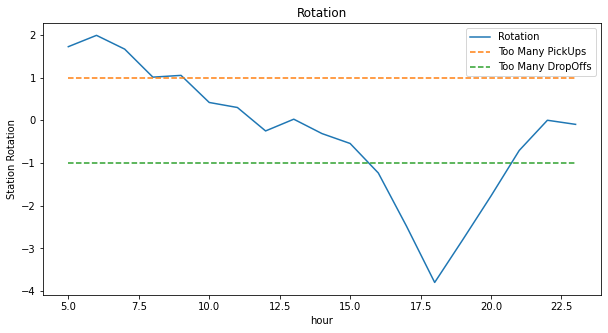

In [215]:
df_2019_hour_clf = df_2019.groupby(by='hour').mean().reset_index()
df_2019_hour_clf['hour'] = df_2019_hour_clf['hour'].astype(int)
fig, axes = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_2019_hour_clf , x='hour', y='rotation', label='Rotation')

y1 = [1]*len(df_2019_hour_clf)
y2 = [-1]*len(df_2019_hour_clf)

sns.lineplot(data=df_2019_hour_clf , x='hour', y=y1, label='Too Many PickUps', linestyle='--')
sns.lineplot(data=df_2019_hour_clf , x='hour', y=y2, label='Too Many DropOffs', linestyle='--')

plt.title('Rotation')
plt.ylabel('Station Rotation');

In this case all the periods above the 'Too Many PickUps' line would require the station to be filled up again. The periods with 'Too Many DropOffs' would require the opposite, that the bicycles there should be distributed to other stations. In this way the prediction problem would become simpler, becoming a simple classification problem.

### Using Weather Data

Some days with rain will definitely reduce demand, and this data could have been used for improving the forecast